# Validation Thresholds

The validation thresholds for Qwen3-235B were computed following the standard validation threshold computation methodology. Full details of this process are documented in [`proposals/models/README.md`](../README.md).

This notebook suggest an analysis part given the precomputed raw data from inference-validation cycles. You can reproduce this analysis here. 

If you want to reproduce the full procedure, including the inference-validation cycles, you'll need to refer to the [`proposals/models/README.md`](../README.md) and learn there how to conduct the inference part.

The `inference.py` that produced the raw data for this analysis can be found here: [link](https://github.com/gonka-ai/gonka/blob/1a531d772907ea9253c028d544819a4b0d25d011/mlnode/packages/benchmarks/scripts/inference.py) 

## Overview

Key results of this experiments are:
- **Validation threshold lower and upper bounds**: `0.041`, `0.042`
- **Fraud Detection Rate**: **24%**

These thresholds ensure robust fraud detection while accommodating legitimate hardware-induced variations in probability distributions.

All inference-validation cycle results, including full JSONL datasets and configuration files, are available in the shared Google Drive folder [Qwen235B Validation Data](https://drive.google.com/drive/folders/1yPCZg_hh3Ab4upvF7TcXoeMLJUIpBif2?usp=sharing), which includes a) Complete inference-validation JSONL files; b) Configuration JSON files for each run.  

IMPORTANT: if you want the code below to work, you'll need to download the files and define the path to this files below.

**GDrive with data**: [Qwen235B Validation Data](https://drive.google.com/drive/folders/1yPCZg_hh3Ab4upvF7TcXoeMLJUIpBif2?usp=sharing)

## Data preparation

Below is the analysis code for the resulting raw data from inference-validation cycles.

To be able to analyse the results yourself, you need:
1. Download the raw data and configs
2. Put all the files, including raw data and configs to one place
3. Set `gonka_path` (path to the gonka project) and `data_path` (path to the folder containining downloaded data) correctly to be able to import the code and files.
4. Run the code cells

In [1]:
%load_ext autoreload
%autoreload 2
gonka_path = '/root/gonka'

import sys
import os
sys.path.append(os.path.join(gonka_path, 'mlnode/packages/benchmarks/src'))
sys.path.append(os.path.join(gonka_path, 'mlnode/packages/common/src'))
import os
import copy
import numpy as np

from validation.data import load_from_jsonl

from validation.analysis import generate_name_from_config, find_optimal_bounds_parallel, evaluate_bound, classify_data
from validation.analysis import analyze, process_data, plot_classification_results, plot_length_vs_distance_comparison
from validation.analysis import plot_violin_comparison

### Test Configurations

**Honest inference scenarios** test the acceptable distance range when both inference and validation use the same model (FP8 precision):
1. **4xH100 vs 4xH200**: Cross-hardware validation

**Fraudulent Inference Scenarios** test fraud detection capability when inference uses an INT4 quantization ([Qwen3-235B-A22B-Instruct-2507-INT4-W4A16](https://huggingface.co/chriswritescode/Qwen3-235B-A22B-Instruct-2507-INT4-W4A16)) while validation uses the correct FP8 model. 
1. **4xH100 (INT4) vs 4xH100 (FP8)**: Primary fraud detection test

Below you'll see how each test scenarios' raw file is loaded.

In [2]:
model_name = 'qwen235B'

##### This part should be changed according to the path where json files are generated or downloaded #######
data_path = os.path.join(gonka_path, 'mlnode/packages/benchmarks/data/inference_results')


honest_data_paths = [
    os.path.join(data_path, 'Qwen3-235B-A22B-Instruct-2507-FP8-fp8-4xH100___Qwen3-235B-A22B-Instruct-2507-FP8-fp8-4xH200__235_repro__2025-10-21_1757.jsonl'),
]

fraud_data_paths = [
    os.path.join(data_path, 'Qwen3-235B-A22B-Instruct-2507-INT4-W4A16-int4-4xH100___Qwen3-235B-A22B-Instruct-2507-FP8-fp8-4xH100__235_repro__2025-10-21_1732.jsonl'),
]
##############################################################################################################

#generate_name_from_config looks for a config file in the same folder, where the raw data is
DATA_PATH = {generate_name_from_config(dp, model_name): dp for dp in honest_data_paths + fraud_data_paths}

Below are some preparation steps: get the distances and items from the raw data

In [3]:
honest_items_dict, honest_distances_dict = {}, {}
fraud_items_dict, fraud_distances_dict = {}, {}
honest_distances, fraud_distances = [], []

for name, path in DATA_PATH.items():
    items, distances, topk = process_data(load_from_jsonl(path, n=1000))
    if 'honest' in name:
        honest_items_dict[name] = items
        honest_distances_dict[name] = distances
        honest_distances.extend(distances)
    if 'fraud' in name:
        fraud_items_dict[name] = items
        fraud_distances_dict[name] = distances
        fraud_distances.extend(distances)

Dropped 0 / 1000 items
Dropped 0 / 1000 items


## Finding the optimal thresholds

The resulting threshold is set up to bring False Positive Rate to zero and minimize F1-score.

The threshold is computed based on all the computed honest and fraud inference-validation scenarios.

In [4]:
optimal_lower, optimal_upper = find_optimal_bounds_parallel(honest_distances, fraud_distances, n_jobs=64, step=0.001)

Searching optimal bounds:   0%|                                                                               | 0/127 [00:00<?, ?it/s]

Searching optimal bounds: 100%|████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 149.95it/s]


Optimal Lower Bound: 0.040733
Optimal Upper Bound: 0.041733
Best F1-Score: 0.4000


## Distances Distribution Analysis

In [5]:
print(f"Thresholds: {optimal_lower:.4f}, {optimal_upper:.4f}")

classifications_honest = classify_data(honest_distances, optimal_lower, optimal_upper)
classifications_fraud = classify_data(fraud_distances, optimal_lower, optimal_upper)

Thresholds: 0.0407, 0.0417


#### Honest Classification

This plot shows the distribution of validation distances for legitimate (honest) inferences using the correct FP8 model on both sides. The vast majority of honest inferences have very low distances (< 0.015), well below the fraud detection threshold.

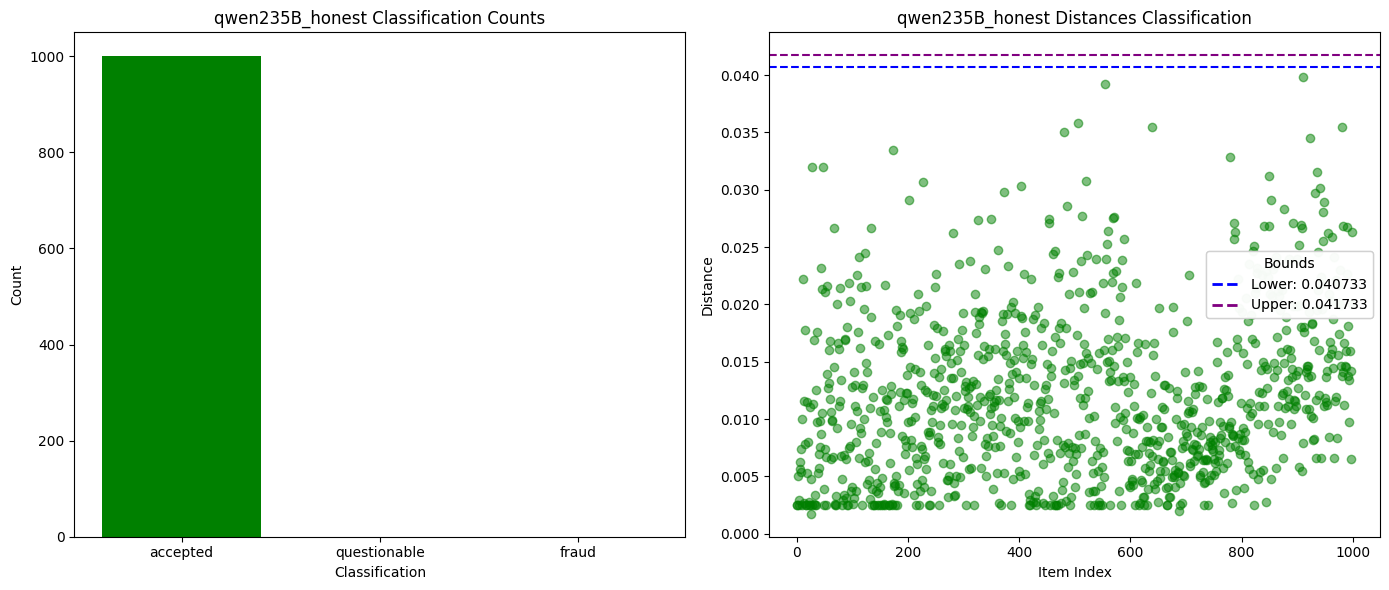

In [6]:
plot_classification_results(
    honest_distances,
    classifications_honest,
    optimal_lower, optimal_upper,
    title_prefix=f"{model_name}_honest",
    # save_to='../data/graphs' 
)

#### Fraud Classification

This plot illustrates how fraudulent inferences produce significantly higher validation distances. The threshold bounds separate a substantial portion of fraud cases from honest behavior.

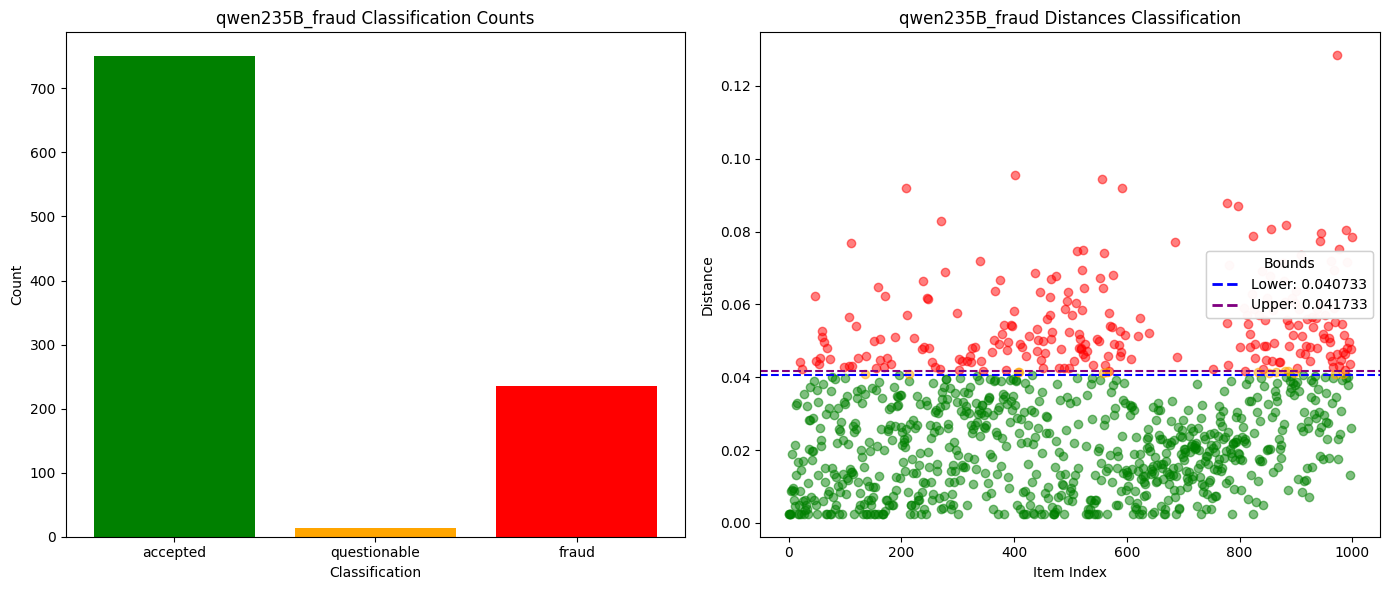

In [7]:
plot_classification_results(
    fraud_distances,
    classifications_fraud,
    optimal_lower,
    optimal_upper,
    title_prefix=f"{model_name}_fraud",
    # save_to='../data/graphs'
)

#### Length vs Distance Comparison

This scatter plot examines the relationship between response length and validation distance across different configurations with different inference request languages. It is a birdview graph to understand the distance distributions.

- **Blue and red/orange points**: honest and fraud inferences
- **Marker shapes**: language of inference request
- **Horizontal lines**: lower and upper threshold bounds

Share of fraud found = 0.236


/root/gonka/mlnode/packages/benchmarks/src/validation/analysis.py:359: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


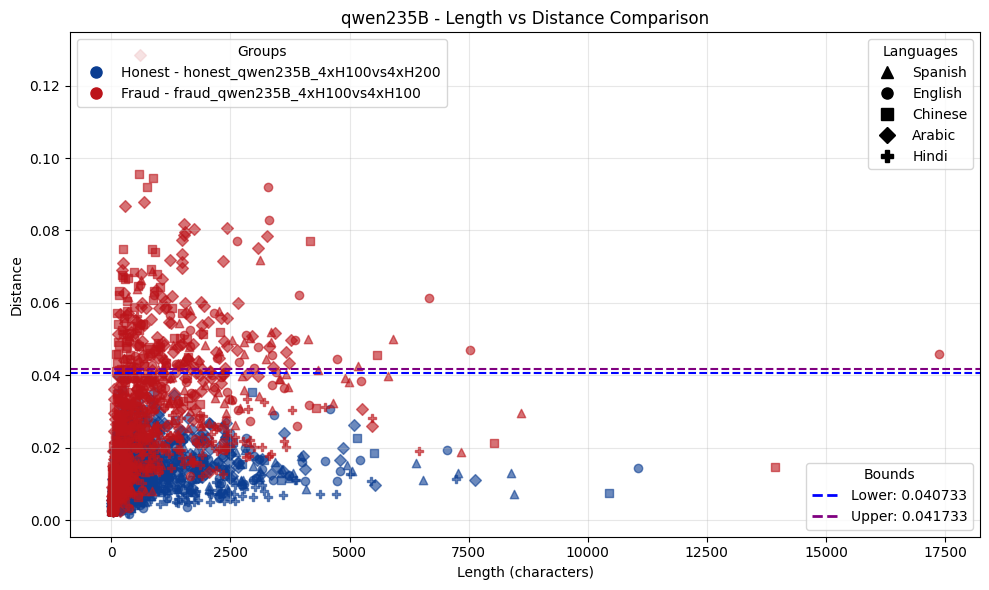

In [8]:
print('Share of fraud found =', sum(np.array(classifications_fraud) == 'fraud')/len(classifications_fraud))
plot_length_vs_distance_comparison(
    model_name,
    honest_items_dict,
    honest_distances_dict,
    fraud_items_dict,
    fraud_distances_dict,
    bounds = (optimal_lower, optimal_upper),
    # save_to='../data/graphs'
)


#### Conclusion

The inference results of [Qwen3-235B-A22B-Instruct-2507-FP8](https://huggingface.co/Qwen/Qwen3-235B-A22B-Instruct-2507-FP8) can be separated from the results of its quantized version, but the accuracy isn't that high.

For now, we could work with it, but it'll need some improvement in the future to increase the gap betwean fraudulent and honest inference requests.